In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from datetime import datetime
import pymc3 as pm
import arviz as az
from scipy.stats import norm
from scipy import  stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import arch 
pd.set_option('display.max_rows',200)
import time

import warnings
warnings.filterwarnings("ignore")


In [3]:
#上证50
df1=pd.read_csv('./上证50ETF.csv',index_col=0)
#df1['returns']=df1['CLOSE'].pct_change()
df1['returns']=np.log(df1['CLOSE']).diff()
df1['history_volatility']=df1['returns'].rolling(20).std()*np.sqrt(250)
df1=df1['2020/1/23':'2020/9/23']
df1=df1[['CLOSE','returns','history_volatility']]

#期权
df2=pd.read_csv('./50ETF购2020年9月.csv',index_col=0)

#国债利率
df3=pd.read_csv('./国债利率.csv',index_col=0)
df3=df3.fillna(method='pad')/100
df3=df3['2020/1/23':'2020/9/23']

In [4]:
df1.head()

,CLOSE,returns,history_volatility
DateTime,,,
2020/1/23,2.925,-0.027316,0.150674
2020/2/3,2.707,-0.077453,0.306782
2020/2/4,2.785,0.028407,0.328273
2020/2/5,2.801,0.005729,0.323721
2020/2/6,2.842,0.014532,0.329823


In [5]:
df2.head()

,10002231.SH2.80,10002232.SH2.85,10002233.SH2.90,10002234.SH2.95,10002235.SH3.00,10002236.SH3.10,10002237.SH3.20,10002238.SH3.30
DateTime,,,,,,,,
2020/1/23,0.3165,0.2852,0.2516,0.2247,0.1987,0.1545,0.1172,0.0877
2020/2/3,0.1743,0.1558,0.1372,0.1244,0.1060,0.0847,0.0666,0.0535
2020/2/4,0.2034,0.1800,0.1591,0.1392,0.1212,0.0921,0.0701,0.0525
2020/2/5,0.1961,0.1716,0.1501,0.1301,0.1116,0.0836,0.0612,0.0454
2020/2/6,0.2215,0.1928,0.1723,0.1484,0.1318,0.0995,0.0740,0.0555


In [7]:
def get_data(name):
    df=pd.DataFrame(df2[name])
    df.columns=['price']
    df['K']=float(name[-4:])
    T=datetime.strptime('2020-9-23', '%Y-%m-%d')
    df['T']=((T-pd.DatetimeIndex(df2.index)).days.values+1)/365
    df['S']=df1['CLOSE'].values
    df['r']=df3['TB1Y.WI'].values
    return df
    

# BS模型

In [8]:
def my_bs_call(S, K, T, r, sigma):
    if np.isnan(sigma):
        return np.nan
    d1 = (np.log(S/K) + (r+.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    N1, N2 = norm.cdf(d1), norm.cdf(d2)
    return S*N1 - K*np.exp(-r*T)*N2

# GARCH(1,1)

In [9]:
am = arch.arch_model(df1['returns'].values) 
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.5911892359463616e+16
Iteration:      2,   Func. Count:     16,   Neg. LLF: -458.6680677560253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -458.66806809896565
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                458.668
Distribution:                  Normal   AIC:                          -909.336
Method:            Maximum Likelihood   BIC:                          -896.961
                                        No. Observations:                  163
Date:                Sat, May 28 2022   Df Residuals:                      159
Time:                        22:59:05   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.6908e-04  8.556e-04      1.016      0.310 [-8.078e-04,2.546e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6356e-05  2.938e-06      8.971  2.934e-19 [2.060e-05,3.211e-05]
alpha[1]       0.2000      0.139      1.438      0.150  [-7.251e-02,  0.473]
beta[1]        0.7000  7.987e-02      8.764  1.884e-18     [  0.543,  0.857]
============================================================================

Covariance estimator: robust
"""

In [10]:
g_sigma=res.conditional_volatility*np.sqrt(250)

In [11]:
def MSE(x,y):
    DF=pd.DataFrame([x,y]).T
    DF.columns=['predict','real']
    DF=DF.dropna(axis=0)
    return mean_squared_error(DF['predict'],DF['real'])

In [12]:
h_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=df1['history_volatility'].values[i])
        predict.append(result)
    predict=np.array(predict)
    h_mse.append(MSE(predict,df['price'].values))
mse=pd.DataFrame(h_mse)
mse.columns=['history-BS']
mse.index=df2.columns[:10]

In [13]:
garch_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=g_sigma[i])
        predict.append(result)
    predict=np.array(predict)
    garch_mse.append(MSE(predict,df['price'].values))


In [14]:
mse['Garch-BS']=garch_mse
mse

,history-BS,Garch-BS
10002231.SH2.80,0.001889,0.003361
10002232.SH2.85,0.002017,0.003467
10002233.SH2.90,0.002131,0.003500
10002234.SH2.95,0.002209,0.003558
10002235.SH3.00,0.002203,0.003581
10002236.SH3.10,0.002281,0.003610
10002237.SH3.20,0.002202,0.003509
10002238.SH3.30,0.002090,0.003404


# SV

history_volatility_mse=[]
for name in df2.columns:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        result=my_bs_call(S, K, T, r=0.05, sigma=df1['history_volatility'].values[i])
        predict.append(result)
    predict=np.array(predict)
    history_volatility_mse.append(mean_absolute_error(predict,df['price'].values))

mse['history_volatility-BS']=history_volatility_mse

In [15]:
def make_stochastic_volatility_model2(data):
    with pm.Model() as model:
        mu = pm.Normal('mu',0,0.1)
        fi1=pm.Beta('fi1',20,1.5)
        fi=2*fi1-1
        tau=pm.Gamma('tau',2.5,0.025)
        v = pm.AR1("v", k=fi,tau_e=tau, shape=len(data))
        volatility=v+mu
        nu = pm.ChiSquared("nu", 8)
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-1 * volatility), observed=data['returns'])
    return model


stochastic_vol_model2 = make_stochastic_volatility_model2(df1)


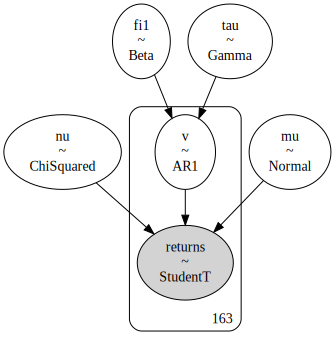

In [16]:
pm.model_to_graphviz(stochastic_vol_model2)

In [17]:
with stochastic_vol_model2:
    #start=pm.find_MAP()
    step=pm.NUTS()
    trace = pm.sample(draws=20000, tune=20000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, v, tau, fi1, mu]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 1065 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.005,0.101,-0.194,0.187,0.000,0.000,49510.0,53162.0,1.0
v[0],-7.673,0.659,-8.915,-6.450,0.007,0.005,8106.0,21507.0,1.0
v[1],-7.696,0.626,-8.849,-6.500,0.007,0.005,7336.0,23709.0,1.0
v[2],-7.844,0.587,-8.924,-6.713,0.005,0.003,14384.0,32876.0,1.0
v[3],-8.018,0.572,-9.070,-6.918,0.003,0.002,36400.0,45186.0,1.0
v[4],-8.163,0.564,-9.215,-7.093,0.002,0.002,54906.0,54133.0,1.0
v[5],-8.302,0.571,-9.355,-7.204,0.003,0.002,45130.0,39374.0,1.0
v[6],-8.409,0.575,-9.480,-7.315,0.003,0.002,30504.0,27554.0,1.0
v[7],-8.485,0.570,-9.585,-7.434,0.004,0.003,23139.0,26805.0,1.0
v[8],-8.553,0.573,-9.658,-7.502,0.004,0.003,17840.0,22463.0,1.0


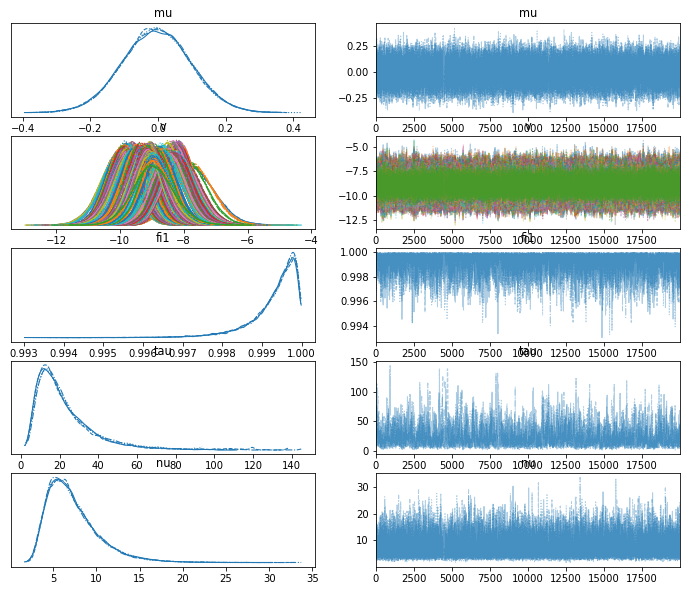

In [18]:
pm.traceplot(trace)
pm.summary(trace)

In [28]:
pm.summary(trace).to_excel('./data2020result/mcresult.xlsx')

Got error No model on context stack. trying to find log_likelihood in translation.


In [21]:
sv_sigma=np.sqrt(np.exp(pd.DataFrame(trace['v']).T.mean(axis=1).values+np.mean(trace['mu'])))*np.sqrt(250)
sv_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=sv_sigma[i])
        predict.append(result)
    predict=np.array(predict)
    sv_mse.append(MSE(predict,df['price'].values))

mse['SV-BS']=sv_mse
mse

,history-BS,Garch-BS,SV-BS
10002231.SH2.80,0.001889,0.003361,0.000866
10002232.SH2.85,0.002017,0.003467,0.000902
10002233.SH2.90,0.002131,0.003500,0.000925
10002234.SH2.95,0.002209,0.003558,0.000916
10002235.SH3.00,0.002203,0.003581,0.000923
10002236.SH3.10,0.002281,0.003610,0.000809
10002237.SH3.20,0.002202,0.003509,0.000715
10002238.SH3.30,0.002090,0.003404,0.000677


In [23]:
h_sigma=df1['history_volatility'].values

In [24]:
def option_plot(name):
    df=get_data(name)
    h_predict=[]
    g_predict=[]
    sv_predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        h_result=my_bs_call(S, K, T, r, sigma=h_sigma[i])
        g_result=my_bs_call(S, K, T, r, sigma=g_sigma[i])
        sv_result=my_bs_call(S, K, T, r, sigma=sv_sigma[i])
        h_predict.append(h_result)
        g_predict.append(g_result)
        sv_predict.append(sv_result)
    result=pd.DataFrame(df['price'])
    result['hv-BS']=h_predict
    result['Garch-BS']=g_predict
    result['Bayesian-BS']=sv_predict
    result=result.dropna()
    result.plot(figsize=(12,10))
    plt.title(f'K={name[-4:]}')
    return result

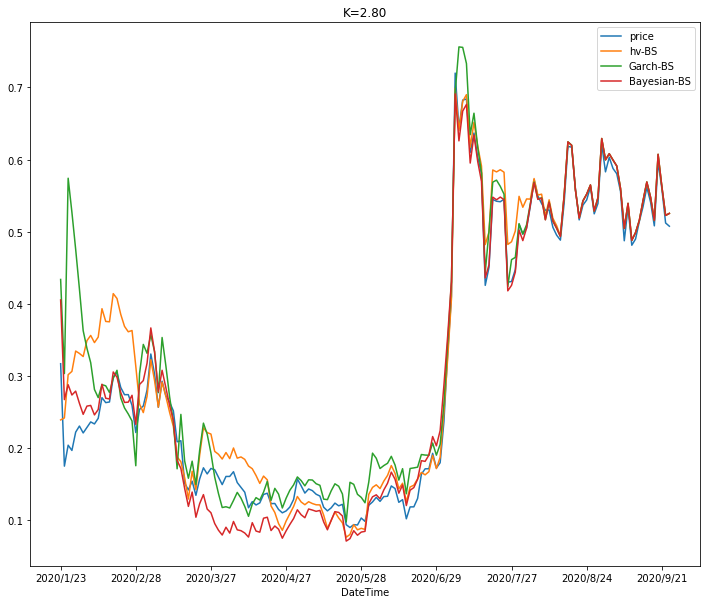

In [38]:
df=option_plot(df2.columns[0])

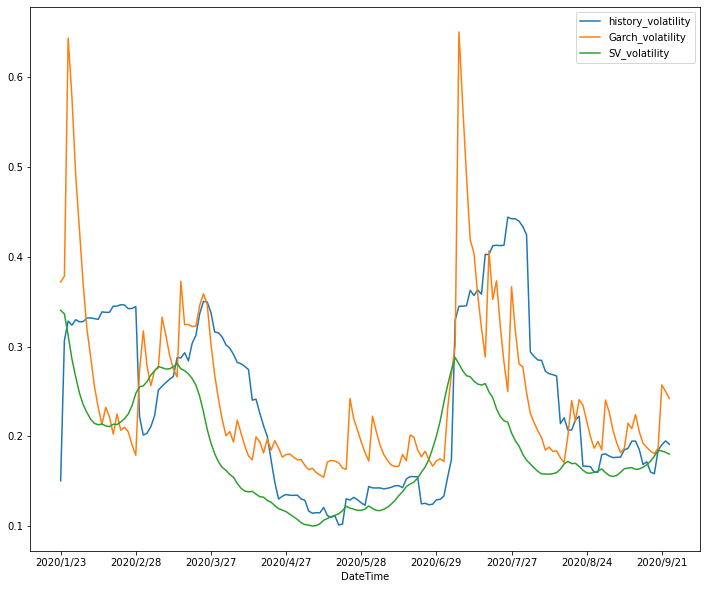

In [22]:
vol=df1.copy()
vol['Garch_volatility']=g_sigma
vol['SV_volatility']=sv_sigma
vol=vol[['history_volatility','Garch_volatility','SV_volatility']]
vol.plot(figsize=(12,10))